## Credit Card Approval Prediction using Machine Learning

Commercial banks receive a lot of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do.

### Step 1 : Import the necessary libraries

In [76]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

I'm storing my **SageMaker variables** in the next cell:
* sagemaker_session: The SageMaker session we'll use for training models.
* bucket: The name of the default S3 bucket that we'll use for data storage.
* role: The IAM role that defines our data and model permissions.

In [77]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

## Step 2 : Loading and Exploring the Data

Next, I am loading the data from my uploaded csv file, i.e the 'credit-approval_csv - pandas.csv'.

It's important to look at the distribution of data since this will inform how we develop a credit card approval prediction model. We'll want to know: How many data points we have to work with, the number and type of features, and finally, the distribution of data over the classes (approved or not approved).

In [78]:
credit = pd.read_csv('credit-approval_csv - pandas.csv')
credit

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260.0,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200.0,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200.0,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280.0,750,-


In [79]:
credit.describe()

,Age,Debt,YearsEmployed,CreditScore,ZipCode,Income
count,678.000000,690.000000,690.000000,690.00000,677.000000,690.000000
mean,31.568171,4.758725,2.223406,2.40000,184.014771,1017.385507
std,11.957862,4.978163,3.346513,4.86294,173.806768,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.602500,1.000000,0.165000,0.00000,75.000000,0.000000
50%,28.460000,2.750000,1.000000,0.00000,160.000000,5.000000
75%,38.230000,7.207500,2.625000,3.00000,276.000000,395.500000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100000.000000


In [80]:
print('Data shape (rows, cols): ', credit.shape)
print()

Data shape (rows, cols):  (690, 16)



## Step 3 : Data Pre-Processing

### Dealing With Missing Values

Our missing values have taken a disguise as question marks in categorical columns. To deal with this, I'll first replace all question marks with np.NaNs, then I'll build out a loop that will iterate over each column and determine if it is an object type then impute the most common value for each of those columns.

In [81]:
# Replace "?" with NaN
credit.replace('?', np.NaN, inplace = True)
# Convert Age to numeric
credit["Age"] = pd.to_numeric(credit["Age"])

In [82]:
#replace missing values with mean values of numeric columns
credit.fillna(credit.mean(), inplace=True)

An important question that gets raised here is “why are we giving so much importance to missing values?” Can’t they be just ignored? Ignoring missing values can affect the performance of a machine learning model heavily. While ignoring the missing values our machine learning model may miss out on information about the dataset that may be useful for its training. Then, there are many models which cannot handle missing values implicitly such as LDA.
So, to avoid this problem, we are going to impute the missing values with a strategy called mean imputation.

In [83]:
def imputeWithMode(df):
    """ 
    Going through each columns and checking the type is object
    if it is object, impute it with most frequent value
    """
    for col in df:
        if df[col].dtypes == 'object':
            df[col] = df[col].fillna(df[col].mode().iloc[0])
imputeWithMode(credit)

Also, feature like DriversLicense is not as important as the other features in the dataset for predicting credit card approvals. I should drop it to design my machine learning model with the best set of features. In Data Science literature, this is often referred to as feature selection.

In [84]:
credit_drop=credit

In [85]:
credit_drop=credit.drop(["ZipCode"],axis=1)

In [86]:
credit_drop=credit_drop.drop(["DriversLicense"],axis=1)

In [87]:
credit_drop

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,g,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,g,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,g,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,g,750,-


In [88]:
credit_drop.describe

<bound method NDFrame.describe of     Gender    Age    Debt Married BankCustomer EducationLevel Ethnicity  \
0        b  30.83   0.000       u            g              w         v   
1        a  58.67   4.460       u            g              q         h   
2        a  24.50   0.500       u            g              q         h   
3        b  27.83   1.540       u            g              w         v   
4        b  20.17   5.625       u            g              w         v   
..     ...    ...     ...     ...          ...            ...       ...   
685      b  21.08  10.085       y            p              e         h   
686      a  22.67   0.750       u            g              c         v   
687      a  25.25  13.500       y            p             ff        ff   
688      b  17.92   0.205       u            g             aa         v   
689      b  35.00   3.375       u            g              c         h   

     YearsEmployed PriorDefault Employed  CreditScore Citizen  In

## Further Pre-Processing of Dataframe

Even after this imputation, I still have pre-processing procedures to complete before I build out my ML models. Currently, I am still dealing with data broken down into numerical and categorical designations. To deal with this, I'll build-out another loop that will iterate over all of my columns, check if it’s an object type, and use label encoder to create appropriate numerical values for those respective columns.

A note on LabelEncoder from the sklearn module pre-processing; it is an excellent tool and one that will designate target labels with a value between 0 and n_classes — 1.

In [89]:
#LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
#Looping for each object type column
#Using label encoder to convert into numeric types
for col in credit_drop:
    if credit_drop[col].dtypes=='object':
        credit_drop[col]=LE.fit_transform(credit_drop[col])

In [90]:
credit_drop.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,560,0
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,824,0
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,0,3,0
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,2,0,0


In [105]:
def approval_percentage(credit_drop):
    '''Calculate the fraction of all data points that have a 'Class' label of 1; approved.
       :param transaction_df: Dataframe of all transaction data points; has a column 'Approve'
       :return: A fractional percentage of fraudulent data points/all points
    '''
    # counts for all classes
    counts = credit_drop['Approved'].value_counts()
    
    # get approval and noapproval cnts
    approval_cnts = counts[1]
    noapproval_cnts = counts[0]
    
    # calculate percentage of approved data
    approval_percentage = approval_cnts/(approval_cnts+noapproval_cnts)
    
    return approval_percentage

# call the function to calculate the approval percentage
approval_percentage = approval_percentage(credit_drop)

print('Approval percentage = ', approval_percentage)
print('Total # of approved pts: ', approval_percentage*credit_drop.shape[0])
print('Out of (total) pts: ', credit_drop.shape[0])

Approval percentage =  0.5550724637681159
Total # of approved pts:  383.0
Out of (total) pts:  690


## Step 4 : Data Visualization

### One Hot Encoding

In [91]:
#HOT ENCODER
#convert to categorical data to dummy data
credit_dummies = pd.get_dummies(credit_drop, columns=[ "Married","EducationLevel", "Citizen", "Ethnicity"])
credit_dummies.head()

,Gender,Age,Debt,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,Income,Approved,...,Citizen_2,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,Ethnicity_4,Ethnicity_5,Ethnicity_6,Ethnicity_7,Ethnicity_8
0,1,30.83,0.000,0,1.25,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,58.67,4.460,0,3.04,1,1,6,560,0,...,0,0,0,0,1,0,0,0,0,0
2,0,24.50,0.500,0,1.50,1,0,0,824,0,...,0,0,0,0,1,0,0,0,0,0
3,1,27.83,1.540,0,3.75,1,1,5,3,0,...,0,0,0,0,0,0,0,0,1,0
4,1,20.17,5.625,0,1.71,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [92]:
credit_dummies.columns

Index(['Gender', 'Age', 'Debt', 'BankCustomer', 'YearsEmployed',
       'PriorDefault', 'Employed', 'CreditScore', 'Income', 'Approved',
       'Married_0', 'Married_1', 'Married_2', 'EducationLevel_0',
       'EducationLevel_1', 'EducationLevel_2', 'EducationLevel_3',
       'EducationLevel_4', 'EducationLevel_5', 'EducationLevel_6',
       'EducationLevel_7', 'EducationLevel_8', 'EducationLevel_9',
       'EducationLevel_10', 'EducationLevel_11', 'EducationLevel_12',
       'EducationLevel_13', 'Citizen_0', 'Citizen_1', 'Citizen_2',
       'Ethnicity_0', 'Ethnicity_1', 'Ethnicity_2', 'Ethnicity_3',
       'Ethnicity_4', 'Ethnicity_5', 'Ethnicity_6', 'Ethnicity_7',
       'Ethnicity_8'],
      dtype='object')

In [93]:
credit_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             690 non-null    int64  
 1   Age                690 non-null    float64
 2   Debt               690 non-null    float64
 3   BankCustomer       690 non-null    int64  
 4   YearsEmployed      690 non-null    float64
 5   PriorDefault       690 non-null    int64  
 6   Employed           690 non-null    int64  
 7   CreditScore        690 non-null    int64  
 8   Income             690 non-null    int64  
 9   Approved           690 non-null    int64  
 10  Married_0          690 non-null    uint8  
 11  Married_1          690 non-null    uint8  
 12  Married_2          690 non-null    uint8  
 13  EducationLevel_0   690 non-null    uint8  
 14  EducationLevel_1   690 non-null    uint8  
 15  EducationLevel_2   690 non-null    uint8  
 16  EducationLevel_3   690 non

In [94]:
credit_dummies.describe()

,Gender,Age,Debt,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,Income,Approved,...,Citizen_2,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,Ethnicity_4,Ethnicity_5,Ethnicity_6,Ethnicity_7,Ethnicity_8
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,...,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,0.695652,31.568171,4.758725,0.475362,2.223406,0.523188,0.427536,2.40000,1017.385507,0.555072,...,0.082609,0.085507,0.008696,0.082609,0.20000,0.011594,0.005797,0.002899,0.591304,0.011594
std,0.460464,11.853273,4.978163,0.850238,3.346513,0.499824,0.495080,4.86294,5210.102598,0.497318,...,0.275490,0.279838,0.092912,0.275490,0.40029,0.107128,0.075973,0.053799,0.491949,0.107128
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.670000,1.000000,0.000000,0.165000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,28.625000,2.750000,0.000000,1.000000,1.000000,0.000000,0.00000,5.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,37.707500,7.207500,0.000000,2.625000,1.000000,1.000000,3.00000,395.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,80.250000,28.000000,2.000000,28.500000,1.000000,1.000000,67.00000,100000.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


### Graph Plotting for Data Visualization

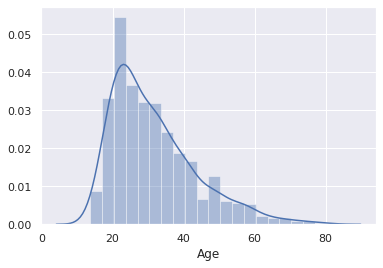

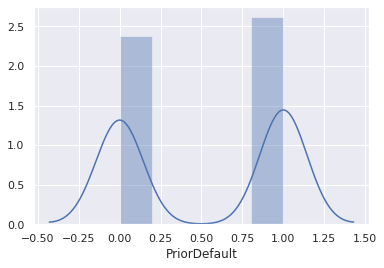

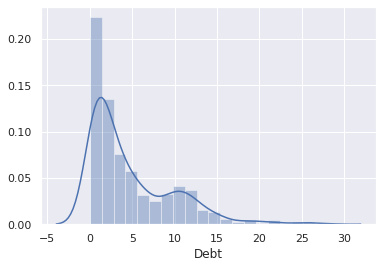

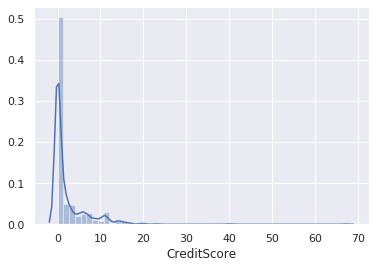

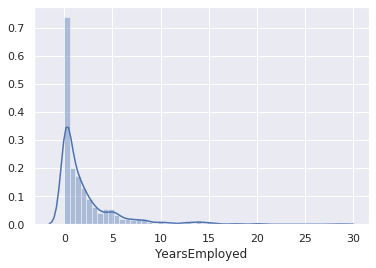

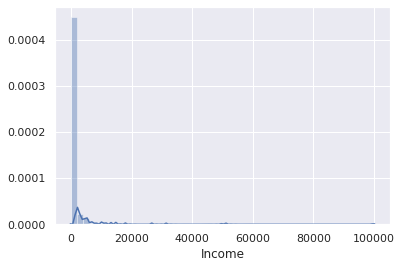

<Figure size 432x288 with 0 Axes>

In [95]:
def plotDistPlot(col):
    """Flexibly plot a univariate distribution of observation"""
    try:
        sns.distplot(col)
    except RuntimeError as re:
        if str(re).startswith("Selected KDE bandwidth is 0. Cannot estimate density."):
            sns.distplot(col, kde_kws={'bw': 1.5})
        else:
            raise re
    plt.show()
    
plotDistPlot(credit_drop['Age'])
plotDistPlot(credit_drop['PriorDefault'])
plotDistPlot(credit_drop['Debt'])
plotDistPlot(credit_drop['CreditScore'])
plotDistPlot(credit_drop['YearsEmployed'])
plotDistPlot(credit_drop['Income'])
plt.savefig('Distribution.jpeg')

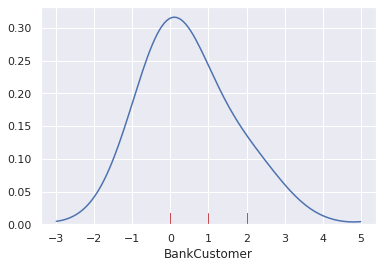

In [71]:
sns.distplot(credit_drop['BankCustomer'], hist = False, rug = True, rug_kws = {'color' : 'r'}, kde_kws = {'bw' : 1})

### Correlation Matrix

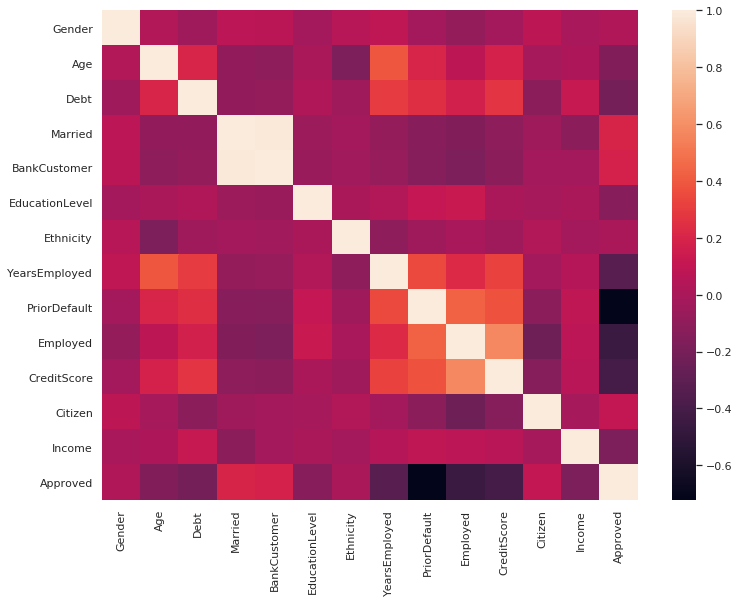

In [96]:
corr = credit_drop.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.savefig('corelation.jpg')

### Scatter Plot using Seaborn

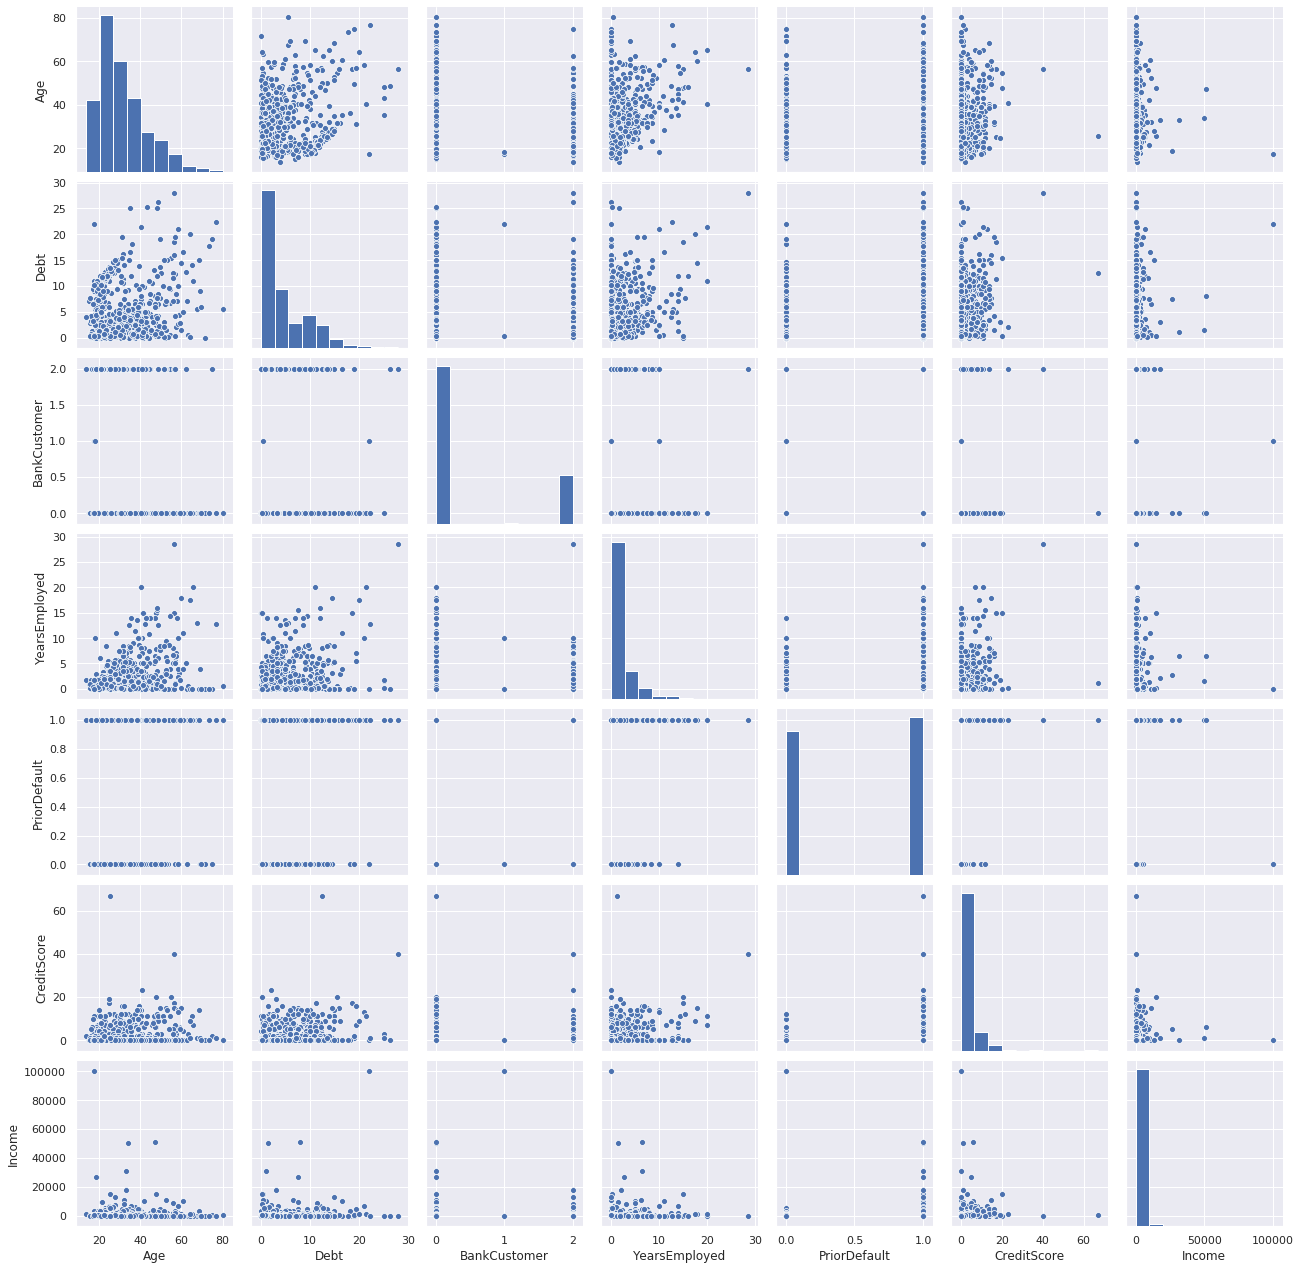

<Figure size 432x288 with 0 Axes>

In [97]:
#scatterplot
sns.set()
cols = ['Age', 'Debt', 'BankCustomer','YearsEmployed','PriorDefault','CreditScore','Income']
sns.pairplot(credit_drop[cols], size = 2.5)
plt.show();
plt.savefig('scatterplot.jpg')

## Step 5: Splitting the dataset into Train and Test Sets

I've successfully converted all the non-numeric values to numeric ones.

Now, I will split our data into train set and test set to prepare my data for two different phases of machine learning modeling: training and testing. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model. Hence, I first split the data and then apply the scaling.

In [98]:
credit_drop.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,560,0
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,824,0
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,0,3,0
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,2,0,0


In [99]:
from sklearn.model_selection import train_test_split
credit_drop_copy = credit_drop
credit_drop_copy

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,560,0
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,824,0
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,0,3,0
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,21.08,10.085,2,2,4,3,1.25,0,0,0,0,0,1
686,0,22.67,0.750,1,0,1,7,2.00,0,1,2,0,394,1
687,0,25.25,13.500,2,2,5,2,2.00,0,1,1,0,1,1
688,1,17.92,0.205,1,0,0,7,0.04,0,0,0,0,750,1


In [100]:
credit_drop_copy = credit_drop_copy.values

In [101]:
X,y = credit_drop_copy[:,0:13] , credit_drop_copy[:,13]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.2,
                                random_state=42)

### Scaling our Data

The data is split into two separate sets — train and test sets, respectively. I am now left with one final pre-processing step of scaling before I can fit a machine learning model to the data.
Using MinMaxScaler, I'll rescale our X_train, and X_test set into values between 0 and 1.

In [117]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

In [122]:
traindf = pd.DataFrame({'Label': y_train, 'Column1': rescaledX_train[:, 0], 'Column2': rescaledX_train[:, 1],'Column3': rescaledX_train[:, 2],'Column4': rescaledX_train[:, 3],'Column5': rescaledX_train[:, 4],'Column6': rescaledX_train[:, 5],'Column7': rescaledX_train[:, 6],'Column8': rescaledX_train[:, 7], 'Column9': rescaledX_train[:, 8], 'Column10': rescaledX_train[:, 9],'Column11': rescaledX_train[:, 10],'Column12': rescaledX_train[:, 11],'Column13': rescaledX_train[:, 12]})
traindf

,Label,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13
0,1.0,1.0,0.162857,0.512626,1.0,1.0,0.384615,0.250,0.00000,0.0,0.0,0.000000,0.0,0.00000
1,1.0,1.0,0.231880,0.132903,0.5,0.0,0.923077,0.875,0.17500,1.0,1.0,0.044776,0.0,0.00000
2,1.0,1.0,0.392180,0.018986,0.5,0.0,0.692308,0.875,0.01250,1.0,0.0,0.000000,1.0,0.00000
3,0.0,1.0,0.184211,0.037972,0.5,0.0,0.769231,0.875,0.08750,1.0,0.0,0.000000,0.0,0.00000
4,0.0,1.0,0.604060,0.365483,0.5,0.0,0.307692,0.875,0.43325,1.0,1.0,0.074627,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,1.0,1.0,0.316992,0.151889,0.5,0.0,0.230769,0.000,0.62500,1.0,0.0,0.000000,0.0,0.00000
548,1.0,1.0,0.225564,0.044238,0.5,0.0,0.615385,0.875,0.02500,1.0,0.0,0.000000,1.0,0.00000
549,0.0,1.0,0.358346,0.000000,0.5,0.0,0.076923,0.875,0.00000,0.0,0.0,0.000000,0.5,0.00000
550,1.0,1.0,0.078947,0.000000,1.0,1.0,0.384615,0.250,0.00000,0.0,1.0,0.059701,0.0,0.00001


In [123]:
testdf = pd.DataFrame({'Label': y_test, 'Column1': rescaledX_test[:, 0], 'Column2': rescaledX_test[:, 1],'Column3': rescaledX_test[:, 2],'Column4': rescaledX_test[:, 3],'Column5': rescaledX_test[:, 4],'Column6': rescaledX_test[:, 5],'Column7': rescaledX_test[:, 6],'Column8': rescaledX_test[:, 7], 'Column9': rescaledX_test[:, 8], 'Column10': rescaledX_test[:, 9],'Column11': rescaledX_test[:, 10],'Column12': rescaledX_test[:, 11],'Column13': rescaledX_test[:, 12]})
testdf

,Label,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13
0,1.0,0.0,0.294292,0.053571,0.5,0.0,0.384615,0.250,0.000000,0.0,1.0,0.050,0.0,0.002055
1,0.0,0.0,0.562791,0.142857,0.5,0.0,0.538462,0.500,0.000000,1.0,0.0,0.000,0.0,0.018787
2,1.0,1.0,0.079070,0.000000,0.5,0.0,0.230769,0.875,0.017544,0.0,0.0,0.000,0.0,0.000000
3,1.0,1.0,0.587535,0.232143,0.5,0.0,0.076923,0.875,0.035088,0.0,0.0,0.000,0.0,0.004462
4,0.0,1.0,0.063628,0.000000,1.0,1.0,0.692308,0.000,0.000000,0.0,0.0,0.000,1.0,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1.0,0.0,0.176744,0.446429,0.5,0.0,0.230769,0.875,0.035088,0.0,0.0,0.000,0.0,0.020783
134,0.0,0.0,0.167442,0.107143,0.5,0.0,0.769231,0.375,0.064386,1.0,1.0,0.475,0.0,0.009785
135,0.0,0.0,0.472930,0.232143,0.5,0.0,0.769231,0.875,0.017544,1.0,1.0,0.075,0.0,0.000000
136,0.0,1.0,0.227907,0.071429,0.5,0.0,0.615385,0.375,0.146140,1.0,1.0,0.050,0.0,0.000000


In [124]:
traindf.to_csv('CreditCardApproval/train.csv') 

In [125]:
testdf.to_csv('CreditCardApproval/test.csv') 

## Step 6 : Uploading the Data to S3

Upload locally-stored train.csv and test.csv file to S3 by using sagemaker_session.upload_data. This function needs to know: where the data is saved locally, and where to upload in S3 (a bucket and prefix).

In [126]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [127]:
# should be the name of directory you created to save your features data
data_dir = 'CreditCardApproval'

# set prefix, a descriptive name for a directory  
prefix = 'creditcardapproval-prediction'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-west-1-995406738675/creditcardapproval-prediction


In [128]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

creditcardapproval-prediction/roughtest.csv
creditcardapproval-prediction/roughtrain.csv
creditcardapproval-prediction/test.csv
creditcardapproval-prediction/train.csv
Test passed!


## Step 7 : Modeling

Now that I've uploaded my training data, it's time to define and train a model!

In this notebook, I'll define and train the SageMaker, built-in algorithm, LinearLearner.

A LinearLearner has two main applications:

1. For regression tasks in which a linear line is fit to some data points, and you want to produce a predicted output value given some data point (example: predicting house prices given square area).
2. For binary classification, in which a line is separating two classes of data and effectively outputs labels; either 1 for data that falls above the line or 0 for points that fall on or below the line.

In this case, I'll be using it for case 2, and I'll train it to separate data into our two classes: approved or not approved.

### Creating a Linear Learner Estimator

In [129]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'creditcardapproval'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=30)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Convert data into a RecordSet format

Next, I've prepared the data for a built-in model by converting the train features and labels into numpy array's of float values. Then I've used the record_set function to format the data as a RecordSet and prepare it for training!

In [131]:
# convert features/labels to numpy
train_x_np = X_train.astype('float32')
train_y_np = y_train.astype('float32')

# create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

### Training the Estimator

After instantiating my estimator, I've trained it with a call to .fit(), passing in the formatted training data

In [132]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-23 13:29:08 Starting - Starting the training job...
2020-12-23 13:29:35 Starting - Launching requested ML instancesProfilerReport-1608730148: InProgress
......
2020-12-23 13:30:35 Starting - Preparing the instances for training......
2020-12-23 13:31:36 Downloading - Downloading input data...
2020-12-23 13:31:56 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/23/2020 13:32:18 INFO 139984713422656] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'a

## Step 8 : Deploy the Trained Model

I've deployed my model to create a predictor. I'll use this to make predictions on our test data and evaluate the model.

In [133]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------------------!CPU times: user 349 ms, sys: 13.1 ms, total: 362 ms
Wall time: 9min 32s


## Step 9 : Evaluate our Model

Once my model is deployed, I can see how it performs when applied to the test data.

Let's first test our model on just one test point, to see the resulting list.

In [136]:
# test one prediction
test_x_np = X_test.astype('float32')
result = linear_predictor.predict(test_x_np[0])

print(result)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.9079181551933289
    }
  }
}
]


### Helper function for Evaluation

The provided function below, takes in a deployed predictor, some test features and labels, and returns a dictionary of metrics; calculating false negatives and positives as well as recall, precision, and accuracy.

In [139]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, X_test, y_test):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(X_test, 50)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(y_test, test_preds).sum()
    fp = np.logical_and(1-y_test, test_preds).sum()
    tn = np.logical_and(1-y_test, 1-test_preds).sum()
    fn = np.logical_and(y_test, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
   # print(pd.crosstab(X_test, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
    print("\n{:<11} {:.3f}".format('Recall:', recall))
    print("{:<11} {:.3f}".format('Precision:', precision))
    print("{:<11} {:.3f}".format('Accuracy:', accuracy))
    print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
metrics = evaluate(linear_predictor, 
                   X_test.astype('float32'), 
                   y_test)

Metrics for simple, LinearLearner.


Recall:     0.853
Precision:  0.795
Accuracy:   0.819



My simple LinearLearner model achieved an accuracy of 81.9% which is good but improvements can be made.

Next, let's delete this endpoint and discuss ways to improve this model.

## Step 10 : Delete the Endpoint

In [140]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [141]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2020-12-23-13-33-37-854


## Step 11 : Improving the Model

The default LinearLearner got a high accuracy, but still classified some data points incorrectly. 

Model optimization

If we imagine that we are designing this model for use in a bank application, we know that users do not want any valid credit card applications to be categorized as not approved. That is, we want to have as few false positives (0s classified as 1s) as possible.

On the other hand, if our bank manager asks for an application that will catch almost all cases of not approved, even if it means a higher number of false positives, then we'd want as few false negatives as possible.

To train according to specific product demands and goals, we do not want to optimize for accuracy only. Instead, we want to optimize for a metric that can help us decrease the number of false positives or negatives.

Optimizing according to a specific metric is called model tuning, and SageMaker provides a number of ways to automatically tune a model.

### Create, Deploy and Evaluate a LinearLearner and tune for higher precision

To aim for a specific metric, LinearLearner offers the hyperparameter binary_classifier_model_selection_criteria, which is the model evaluation criteria for the training dataset.

I will assume that performance on a training set will be within about 5% of the performance on a test set. So, for a precision of about 90%, I'll aim for a bit higher, 95%.

In [186]:
# instantiate a LinearLearner
# tune the model for a higher precision
linear_precision = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='binary_classifier',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=15,
                              binary_classifier_model_selection_criteria='recall_at_target_precision', # target precision
                              target_precision=0.95) # 95% precision

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [187]:
%%time 
# train the estimator on formatted training data
linear_precision.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-23 18:51:00 Starting - Starting the training job...
2020-12-23 18:51:03 Starting - Launching requested ML instancesProfilerReport-1608749459: InProgress
.........
2020-12-23 18:52:55 Starting - Preparing the instances for training......
2020-12-23 18:54:00 Downloading - Downloading input data
2020-12-23 18:54:00 Training - Downloading the training image...
2020-12-23 18:54:25 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/23/2020 18:54:23 INFO 139917406627648] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'qu

In [188]:
%%time 
# deploy and create a predictor
linear_predictor2 = linear_precision.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!CPU times: user 312 ms, sys: 8.51 ms, total: 320 ms
Wall time: 8min 32s


In [189]:
# test one prediction
test_x_np2 = X_test.astype('float32')
result2 = linear_predictor2.predict(test_x_np2[0])

print(result2)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.7777215242385864
    }
  }
}
]


In [192]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate2(predictor, X_test, y_test):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(X_test, 50)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(y_test, test_preds).sum()
    fp = np.logical_and(1-y_test, test_preds).sum()
    tn = np.logical_and(1-y_test, 1-test_preds).sum()
    fn = np.logical_and(y_test, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    print(pd.crosstab(X_test, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
    print("\n{:<11} {:.3f}".format('Recall:', recall))
    print("{:<11} {:.3f}".format('Precision:', precision))
    print("{:<11} {:.3f}".format('Accuracy:', accuracy))
    print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

print('Metrics for first LinearLearner.\n')

# get metrics for linear predictor
metrics2 = evaluate(linear_predictor2, 
                   X_test.astype('float32'), 
                   y_test)

Metrics for first LinearLearner.


Recall:     0.632
Precision:  0.860
Accuracy:   0.768



In [193]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor2)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2020-12-23-18-55-25-995


Aiming for a higher precision led to a further decrease in the accuracy of our model. Hence, next we tried to target a different metric.

### Create, Deploy and Evaluate a LinearLearner and tune for higher recall

To aim for a specific metric, LinearLearner offers the hyperparameter binary_classifier_model_selection_criteria, which is the model evaluation criteria for the training dataset.

I will assume that performance on a training set will be within about 5% of the performance on a test set. So, for a recall of about 85%, I'll aim for a bit higher, 90%.

In [197]:
# instantiate a LinearLearner
# tune the model for a higher recall
linear_recall = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='binary_classifier',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=80,
                              binary_classifier_model_selection_criteria='precision_at_target_recall', # target recall
                              target_recall=0.9) # 90% recall

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [198]:
%%time 
# train the estimator on formatted training data
linear_recall.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2020-12-23 19:30:35 Starting - Starting the training job...
2020-12-23 19:30:58 Starting - Launching requested ML instancesProfilerReport-1608751834: InProgress
......
2020-12-23 19:32:00 Starting - Preparing the instances for training.........
2020-12-23 19:33:31 Downloading - Downloading input data
2020-12-23 19:33:31 Training - Downloading the training image...
2020-12-23 19:34:02 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[12/23/2020 19:33:55 INFO 139818557032256] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'qu

In [199]:
%%time 
# deploy and create a predictor
linear_predictor1 = linear_recall.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!CPU times: user 278 ms, sys: 12.7 ms, total: 291 ms
Wall time: 7min 32s


In [200]:
# test one prediction
test_x_np1 = X_test.astype('float32')
result1 = linear_predictor1.predict(test_x_np1[0])

print(result1)

[label {
  key: "predicted_label"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "score"
  value {
    float32_tensor {
      values: 0.9317794442176819
    }
  }
}
]


In [202]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate1(predictor, X_test, y_test):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(X_test, 50)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(y_test, test_preds).sum()
    fp = np.logical_and(1-y_test, test_preds).sum()
    tn = np.logical_and(1-y_test, 1-test_preds).sum()
    fn = np.logical_and(y_test, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    print(pd.crosstab(X_test, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
    print("\n{:<11} {:.3f}".format('Recall:', recall))
    print("{:<11} {:.3f}".format('Precision:', precision))
    print("{:<11} {:.3f}".format('Accuracy:', accuracy))
    print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

print('Metrics for final LinearLearner Model.\n')

# get metrics for linear predictor
metrics1 = evaluate(linear_predictor1, 
                   X_test.astype('float32'), 
                   y_test)

Metrics for final LinearLearner Model.


Recall:     0.897
Precision:  0.813
Accuracy:   0.848



In [204]:
# delete the predictor endpoint 
delete_endpoint(linear_predictor1)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Deleted linear-learner-2020-12-23-19-37-56-435


We've finally achieved a model with a good accuracy of approximately 85%!

## Step 12 : Final Cleanup of Resources

When I am completely done with training and testing models, I have deleted my entire S3 bucket. 

In [207]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '5BD54E725AD9AF19',
   'HostId': 'i5KEfmOUlF3sdiqBMP470qjatdT/o3EnZNw5DgUeflKIPZK0iXzOaWUTCXUu5jQaDtpAHQAYrso=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'i5KEfmOUlF3sdiqBMP470qjatdT/o3EnZNw5DgUeflKIPZK0iXzOaWUTCXUu5jQaDtpAHQAYrso=',
    'x-amz-request-id': '5BD54E725AD9AF19',
    'date': 'Wed, 23 Dec 2020 20:36:47 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'creditcardapproval/linear-learner-2020-12-23-18-50-59-865/profiler-output/framework/training_job_end.ts'},
   {'Key': 'creditcardapproval/linear-learner-2020-12-23-17-45-01-738/rule-output/ProfilerReport-1608745501/profiler-output/profiler-reports/StepOutlier.json'},
   {'Key': 'creditcardapproval/linear-learner-2020-12-23-17-48-51-551/rule-output/ProfilerReport-1608745731/profiler-output/profiler-report.ipynb'},
   {'Key': 'creditcardapproval

## End of Project